# Semestrální práce - PLI

In [1]:
# Importing Pytorch library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Importing transformers library for working with models from HuggingFace
from transformers import ElectraTokenizer, AutoModel

# Importing re library for regular expressions
import re

# Importing library for calculating F1 score
from sklearn.metrics import f1_score

# Importing library for easing training and visualizing its progress
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
# Loading training data

with open("train_data.utf8", "r", encoding="utf-8") as f:
    text_data = f.read()

# Newline character is replaced with a space

text_data = text_data.replace("\n", "")

# Remove all non-standard characters (keep only a-z, A-Z, Czech alphabet characters, spaces, digits, dot, comma, question mark, and exclamation mark).

text_data_clean = re.sub(r'[^a-zA-Z0-9.,!?áčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ ]', '', text_data)

# Remove duplicate spaces

text_data_clean = re.sub(r'\s+', ' ', text_data_clean).strip()

# Convert all characters to lower-case

#text_data_clean = text_data_clean.lower()

### CapitalizationModel
`CapitalizationModel` uses the Electra architecture, which is loaded via `AutoModel.from_pretrained`, extended with a linear layer `nn.Linear` with 256 input and 2 output features (2 classes), which is applied to each input token. The `forward` function describes the data flow through the model: first through the Electra model and then through the linear layer for the output.

In [20]:
class CapitalizationModel(nn.Module):
    def __init__(self, name):
        super(CapitalizationModel, self).__init__()
        self.electra_model = AutoModel.from_pretrained(name)
        
        self.linear_layer = nn.Linear(in_features=256, out_features=2)

    def forward(self, x, attn_masks):
        x = self.electra_model(x, attention_mask=attn_masks)[0]

        output = self.linear_layer(x)

        return output

### Initialization and Model Setup

We initialize the `CapitalizationModel` with the pre-trained ELECTRA architecture for Czech (`"Seznam/small-e-czech"`). Then, we move the model to the GPU for more efficient computations, if a GPU is available. Otherwise, we use the CPU. Finally, we switch the model to training mode by calling `capitalization_model.train()` to prepare it for learning.

In [4]:
# Model Initialization

capitalization_model = CapitalizationModel("Seznam/small-e-czech")

# Move the model to GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
capitalization_model.to(device)

capitalization_model.train()



cuda


CapitalizationModel(
  (electra_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in

### Data Split into Training and Validation Set

The data is split into training and validation sets using a 5% validation split. This process begins by splitting the cleaned text into individual words and then calculating the total word count.

The index for the split is calculated as 95% of the total word count, which determines the boundary between the training and validation data. The training data includes words from the beginning up to this index, while the validation data includes the rest.

In [5]:
# Splitting the Data into Validation and Training Sets

VALIDATION_SPLIT = 0.05 # 5% of the total data will be used for validation

words = text_data_clean.split(" ")
words_count = len(words)

split_index = round(words_count * (1 - VALIDATION_SPLIT))

train_data = words[0:split_index]
validation_data = words[split_index:words_count]

### Initializing Tokenizer and Defining Tokenization Function

We initialize the `ElectraTokenizer` with the model specific to Czech ("Seznam/small-e-czech") to convert words into tokens. The defined `tokenization` function takes a list of words and, using the tokenizer, creates a list of tokens and assigns labels to them (each word must always have the same number of tokens and labels) based on capitalization: 0 for lowercase letters and 1 for uppercase letters at the beginning of a word. The function supports processing large amounts of data by sequentially adding tokens and labels to lists and returns two lists: tokens and their labels.

For detailed tokenizer description, see [ELECTRA](https://huggingface.co/docs/transformers/v4.14.1/model_doc/electra#transformers.ElectraTokenizer)

Example of a word with an uppercase starting letter: "Libverda"
- Tokens: ['lib', '##ver', '##da'] -> IDs: [5915, 925, 372]
- Labels: [1, 0, 0]

Example of a word with all lowercase letters: "libverda"
- Tokens: ['lib', '##ver', '##da'] -> IDs: [5915, 925, 372]
- Labels: [0, 0, 0]

In [14]:
# Initialization of the tokenizer

tokenizer = ElectraTokenizer.from_pretrained("Seznam/small-e-czech")

In [ ]:
# Tokenization function
# The function accepts a list of words and returns one list of tokens and one list of labels (for the first token, 0 for lowercase, 1 for uppercase)

# It is necessary to disable the addition of special tokens in the tokenizer

def tokenization(data, tokenizer) -> [list, list]:
    # strs = []
    tokens = []
    labels = []

    for word in tqdm(data, desc="Tokenization", mininterval=1.0):
        
        t = tokenizer(word, add_special_tokens=False)
        # strs += tokenizer.convert_ids_to_tokens(t['input_ids'][1:-1])
        tokens += t['input_ids']
        labels += [int(word[0].isupper())] + [0] * (len(t['input_ids']) - 1)
        
        
    return tokens, labels

validation_tokens, validation_labels = tokenization(validation_data, tokenizer)
print(f'Validation: {len(validation_tokens)} tokens, {len(validation_labels)} labels')
# print(f'Excerpt: {validation_tokens[:8]} = {validation_labels[:8]}')

train_tokens, train_labels = tokenization(train_data, tokenizer)
print(f'Train: {len(train_tokens)} tokens, {len(train_labels)} labels')
# print(f'Excerpt: {train_tokens[:8]} = {train_labels[:8]}')


# CHECK: len(validation_tokens) == len(validation_labels) == 1033374

Tokenization: 100%|██████████| 730893/730893 [00:46<00:00, 15633.28it/s]


Validation: 1033970 tokens, 1033970 labels


Tokenization: 100%|██████████| 13886968/13886968 [15:09<00:00, 15274.48it/s]

Train: 19720557 tokens, 19720557 labels


In [7]:
# SAVE tokens
torch.save(torch.stack((torch.tensor(validation_tokens), torch.tensor(validation_labels))), 'valid.pt')
torch.save(torch.stack((torch.tensor(train_tokens     ), torch.tensor(train_labels     ))), 'train.pt')

In [21]:
# LOAD tokens
validation_tokens, validation_labels = (i.tolist() for i in torch.load('valid.pt', weights_only=True))
train_tokens     , train_labels      = (i.tolist() for i in torch.load('train.pt', weights_only=True))

### Batch Generator

The `batch_generator` function is used to create batches from tokens and labels for more efficient model training. Batches are formed by splitting tokens and labels into sequences of a fixed length, which are then grouped into smaller batches determined by the `batch_size`. Each batch also includes a mask that allows the model to distinguish relevant tokens from padding. In this case, where batches have a constant length, all tokens have their mask set to 1.

Example usage:
`train_generator = batch_generator(train_tokens, train_labels, batch_size=8, length=128)`
This creates a generator for the training data with a batch size of 8 and a sequence length of 128 tokens.

In [9]:
# Batch Generator

# token_tensor.shape == mask_tensor.shape == label_tensor.shape == [8,128]

BATCH_SIZE = 8
SEQ_LEN = 128

def batch_generator(tokens, labels, batch_size = 8, length = 128) -> [torch.Tensor, torch.Tensor, torch.Tensor]:

    assert len(tokens) == len(labels)
    # cutoff = len(tokens) // length * length
    delta = length * batch_size
    # token_sequences = tokens[:cutoff]
    # label_sequences = labels[:cutoff]
    batch_count = len(tokens) // delta # Do not count or use the last sequence that does not match the required length
    
    # CHECK: batch_count == 19258

    while(True):
        for i in range(batch_count):
            
            token_tensor = torch.tensor(tokens[i*delta:(i+1)*delta]).reshape(-1, length)
            label_tensor = torch.tensor(labels[i*delta:(i+1)*delta]).reshape(-1, length)
            mask_tensor = torch.ones_like(token_tensor)

            yield token_tensor, mask_tensor, label_tensor
    



train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)

test_batch = next(train_generator)

## CHECK: test_batch[0][1][2] == tensor(1046, dtype=torch.int32)

### Setting Training Parameters

For training the model, we use cross-entropy (`nn.CrossEntropyLoss`) as the loss function, which is suitable for classification tasks. As the optimization algorithm, we choose Adam (`optim.Adam`), which is popular due to its efficiency and adaptive properties. The learning rate is set to 1e-4.

In [8]:
# Setting training parameters

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(capitalization_model.parameters(), lr=1e-4)


### Testing Forward Pass Through the Model

To test the functionality of the model, we will perform a forward pass using one batch from the training data. First, we zero the gradients in the optimizer to prevent their unwanted accumulation. Then, we load one batch of data using `batch_generator` and perform a forward pass through the model with this data. The model output is permuted to meet the expected dimensions of the loss function, to which we apply the calculated loss. Finally, we perform an optimization step.

The F1 metric is the harmonic mean of precision and recall, commonly used as a metric for evaluating classification models, especially in cases where there is class imbalance. The F1 score reaches its best value at 1 (perfect precision and recall) and its worst at 0.

In [9]:
# Model training iteration

optimizer.zero_grad() # Zeroing the gradients in the optimizer to prevent accumulation over multiple iterations

train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)

inputs, masks, labels = next(train_generator)

output = capitalization_model(inputs.to(device), masks.to(device)) # Forward pass through the model
output = output.permute(0,2,1) # Permutation of the model output to meet the expected dimensions for the loss criterion

loss = criterion(output, labels.to(device)) # Calculation of the loss between predictions and actual labels
loss.backward()

optimizer.step()

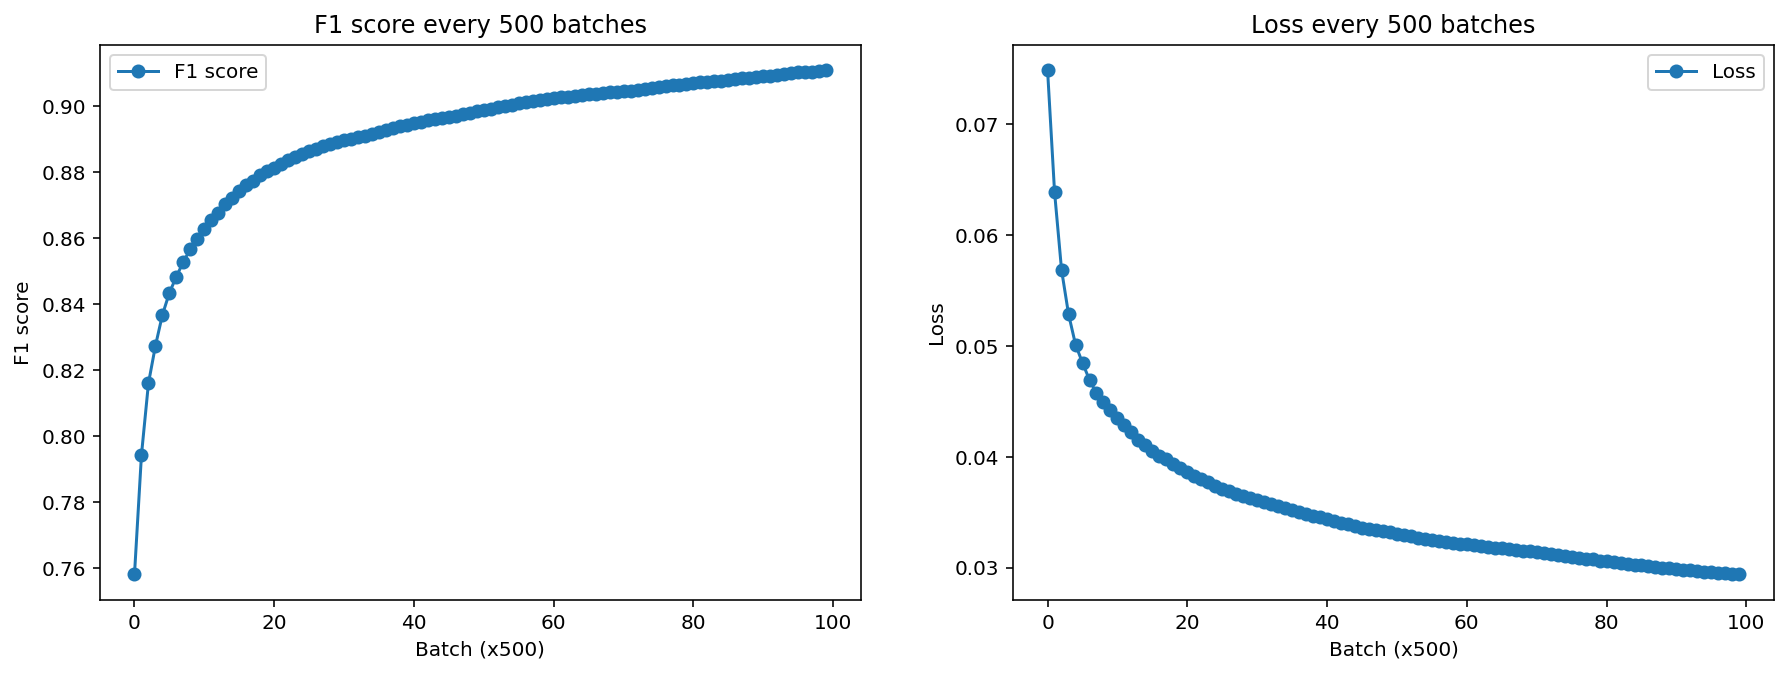

Training Loss: 0.0294 F1 score: 0.9108: 100%|██████████| 50000/50000 [1:05:48<00:00, 12.66it/s]


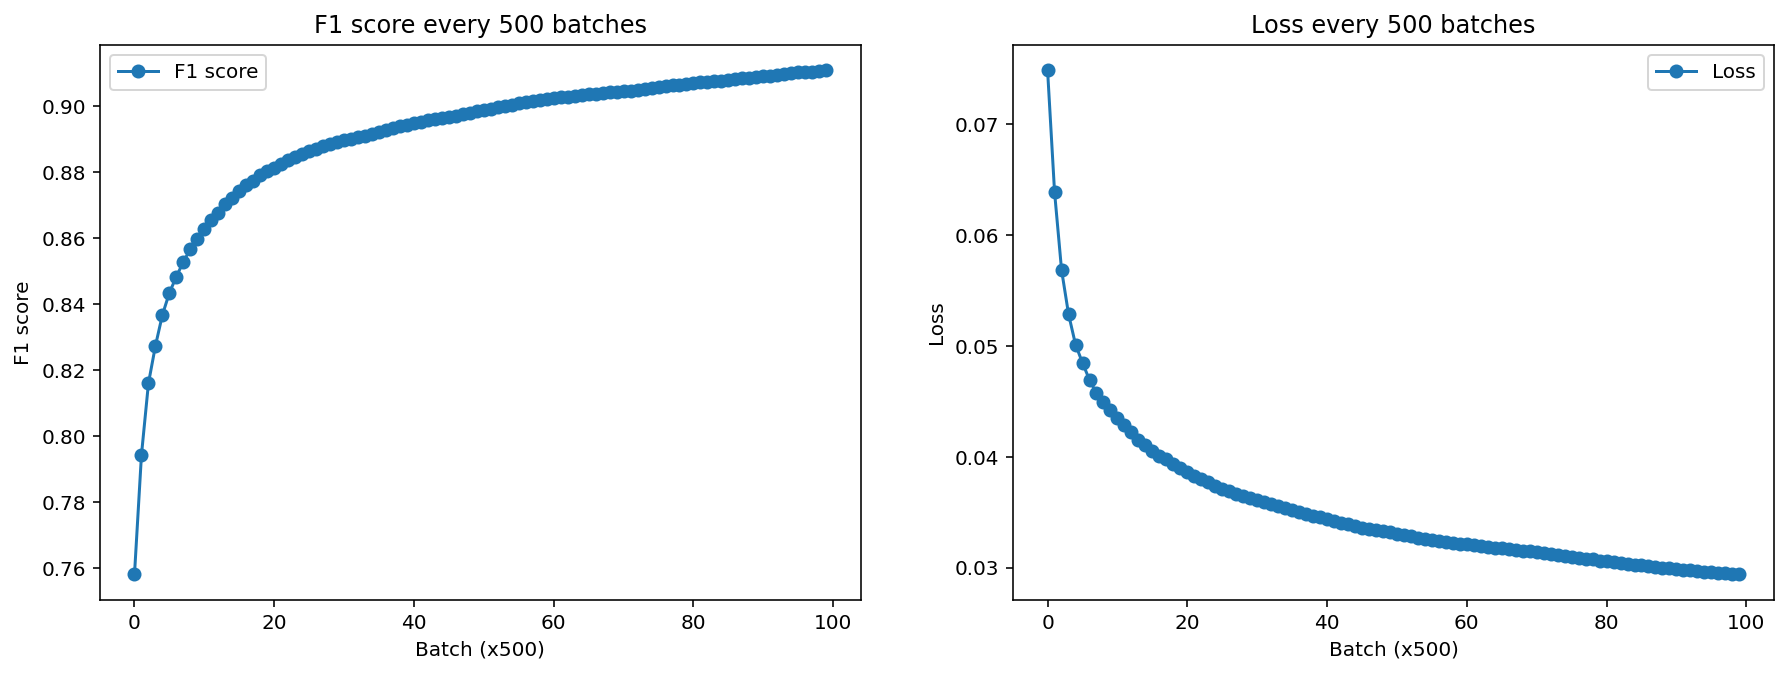

In [10]:
# cfg
BATCH_SIZE = 8

# Initialization of graphs and auxiliary variables for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('F1 score every 500 batches')
ax1.set_xlabel('Batch')
ax1.set_ylabel('F1 score')

ax2.set_title('Loss every 500 batches')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Loss')

running_loss = 0
running_f1 = 0

loss_values = []
f1_scores = []

# Setting the number of iterations for training
t = trange(50000, desc="Training", mininterval=0.5)

# Training loop
for i in t:
    
    # =================================================
    # Take a training step
    # =================================================
    optimizer.zero_grad() # Zeroing the gradients in the optimizer to prevent accumulation over multiple iterations

    try:
        inputs, masks, labels = next(train_generator, None)
    except StopIteration: # TODO this code duplication is kinda ugly
        train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)
        inputs, masks, labels = next(train_generator, None)
    
    output = capitalization_model(inputs.to(device), masks.to(device)) # Forward pass through the model
    output = output.permute(0,2,1) # Permutation of the model output to meet the expected dimensions for the loss criterion
    
    loss = criterion(output, labels.to(device)) # Calculation of the loss between predictions and actual labels
    loss.backward()
    
    optimizer.step()
    
    # =================================================
    # Track running stats
    # =================================================
    running_loss += loss.item()
    f1 = f1_score(torch.argmax(output.clone().detach().cpu(),1).view(-1),labels.view(-1), average=None)
    running_f1 += f1[1]
    t.set_description(f"Training Loss: {(running_loss/(i+1)):.4f} F1 score: {(running_f1/(i+1)):.4f}", refresh=True)
    t.refresh()

    # =================================================
    # Display results every 500 batches
    # =================================================
    if (i+1) % 500 == 0:  # Every 500 batches
        f1_scores.append(running_f1/(i+1))
        loss_values.append(running_loss/(i+1))
        
        # Clearing previous graphs
        ax1.clear()
        ax2.clear()

        # Setting titles and axes for both graphs
        ax1.set_title('F1 score every 500 batches')
        ax1.set_xlabel('Batch (x500)')
        ax1.set_ylabel('F1 score')
        ax2.set_title('Loss every 500 batches')
        ax2.set_xlabel('Batch (x500)')
        ax2.set_ylabel('Loss')

        # Updating the graph for F1 score
        ax1.plot(f1_scores, '-o', label='F1 score')
        ax1.legend()

        # Updating the graph for Loss
        ax2.plot(loss_values, '-o', label='Loss')
        ax2.legend()

        clear_output(wait=True)
        display(fig)  # Displays the current figure with both graphs




Expected chart for loss a F1 skóre (5000x batch).

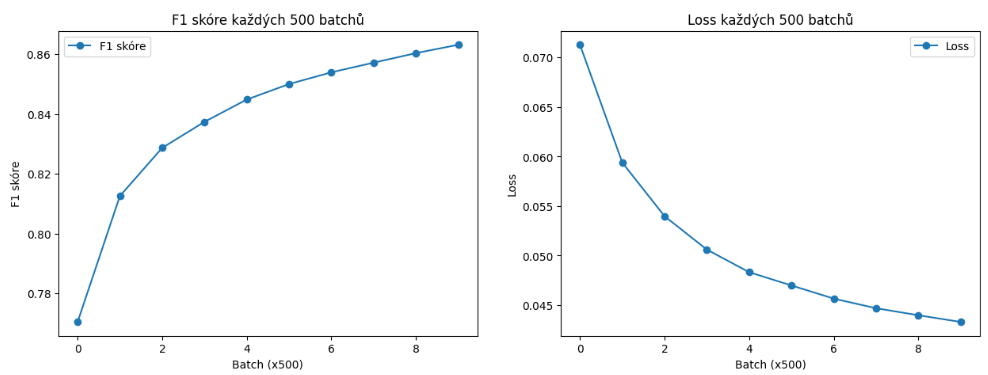

In [11]:
torch.save(capitalization_model, 'capitalization_model.pt')

In [22]:
capitalization_model = torch.load('capitalization_model.pt', weights_only=False)

In [23]:
# Function that takes text as input and generates output text with capitalization
def capitalize(text,model,tokenizer) -> str:
    capitalization_model.eval()
        
    t = tokenizer(text, add_special_tokens=False)
    tokens = t['input_ids']
    strs = tokenizer.convert_ids_to_tokens(tokens)
    
    tokens = torch.tensor(tokens)[None, :]
    mask = torch.ones_like(tokens)
    outputs = model(tokens.to(device), mask.to(device))
    flag = outputs.argmax(axis=-1).squeeze()
    print(flag)

    text_output = ''
    for s, cap in zip(strs, flag):
        if s.startswith('##'):
            s = s[2:]
        elif s not in set(',.?!'):
            text_output += ' '
        if cap:
            s = s[0].upper() + s[1:]
        text_output += s
    
    return text_output[1:]

In [26]:
input_text = "vítejte v liberci, kterým vás provede pan kovář."
print(capitalize(input_text, capitalization_model, tokenizer))

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
vítejte v Liberci, kterým vás provede pan Kovář.


## Bonus

Modify the `tokenization` function so that instead of changing letter case, it can generate punctuation marks (period, comma, and question mark).

For simplicity, consider only the cases where the punctuation mark appears at the end of the word (e.g., "end?").

In total, there will be four classes for classification: No punctuation, Question mark, Period, Comma.

Then, create a `punctuation` function that adds punctuation back into the text.

In [3]:
class PunctuationModel(nn.Module):
    def __init__(self, name):
        super(PunctuationModel, self).__init__()
        self.electra_model = AutoModel.from_pretrained(name)
        
        self.linear_layer = nn.Linear(in_features=256, out_features=4)

    def forward(self, x, attn_masks):
        x = self.electra_model(x, attention_mask=attn_masks)[0]

        output = self.linear_layer(x)

        return output

In [4]:
# Model Initialization

punctuation_model = PunctuationModel("Seznam/small-e-czech")

# Move the model to GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
punctuation_model.to(device)

punctuation_model.train()



cuda


PunctuationModel(
  (electra_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_fe

In [5]:
# Initialization of the tokenizer

tokenizer = ElectraTokenizer.from_pretrained("Seznam/small-e-czech")

In [38]:
def tokenization(data, tokenizer) -> [list, list]:
    # strs = []
    tokens = []
    labels = []
    table = {'.': 1, '?': 2, ',': 3}

    for word in tqdm(data, desc="Tokenization", mininterval=1.0):
        
        t = tokenizer(word, add_special_tokens=False)
        tok = t['input_ids']
        strs = tokenizer.convert_ids_to_tokens(tok)
        for t, s in zip(tok, strs):
            if s in table:
                labels[-1] = table[s]
            else: # Else as to not show the model the punctuation
                tokens.append(t)
                labels.append(0)
        
    return tokens, labels

validation_tokens, validation_labels = tokenization(validation_data, tokenizer)
print(f'Validation: {len(validation_tokens)} tokens, {len(validation_labels)} labels')
# print(f'Excerpt: {validation_tokens[:8]} = {validation_labels[:8]}')

train_tokens, train_labels = tokenization(train_data, tokenizer)
print(f'Train: {len(train_tokens)} tokens, {len(train_labels)} labels')
# print(f'Excerpt: {train_tokens[:8]} = {train_labels[:8]}')


# CHECK: len(validation_tokens) == len(validation_labels) == 1033374

Tokenization: 100%|██████████| 730893/730893 [00:50<00:00, 14461.13it/s]


Validation: 914881 tokens, 914881 labels


Tokenization: 100%|██████████| 13886968/13886968 [15:59<00:00, 14469.25it/s]

Train: 17458980 tokens, 17458980 labels


In [39]:
# SAVE tokens
torch.save(torch.stack((torch.tensor(validation_tokens), torch.tensor(validation_labels))), 'valid2.pt')
torch.save(torch.stack((torch.tensor(train_tokens     ), torch.tensor(train_labels     ))), 'train2.pt')

In [6]:
# LOAD tokens
validation_tokens, validation_labels = (i.tolist() for i in torch.load('valid2.pt'))
train_tokens     , train_labels      = (i.tolist() for i in torch.load('train2.pt'))

/tmp/ipykernel_947633/2280552452.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_tokens, validation_labels = (i.tolist() for i in torch.load('valid2.pt'))
/tm

In [7]:
# Setting training parameters

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(punctuation_model.parameters(), lr=1e-4)


In [8]:
# Batch Generator

# token_tensor.shape == mask_tensor.shape == label_tensor.shape == [8,128]

BATCH_SIZE = 8
SEQ_LEN = 128

def batch_generator(tokens, labels, batch_size = 8, length = 128) -> [torch.Tensor, torch.Tensor, torch.Tensor]:

    assert len(tokens) == len(labels)
    # cutoff = len(tokens) // length * length
    delta = length * batch_size
    # token_sequences = tokens[:cutoff]
    # label_sequences = labels[:cutoff]
    batch_count = len(tokens) // delta # Do not count or use the last sequence that does not match the required length
    
    # CHECK: batch_count == 19258

    while(True):
        for i in range(batch_count):
            
            token_tensor = torch.tensor(tokens[i*delta:(i+1)*delta]).reshape(-1, length)
            label_tensor = torch.tensor(labels[i*delta:(i+1)*delta]).reshape(-1, length)
            mask_tensor = torch.ones_like(token_tensor)

            yield token_tensor, mask_tensor, label_tensor
    



train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)

test_batch = next(train_generator)

## CHECK: test_batch[0][1][2] == tensor(1046, dtype=torch.int32)

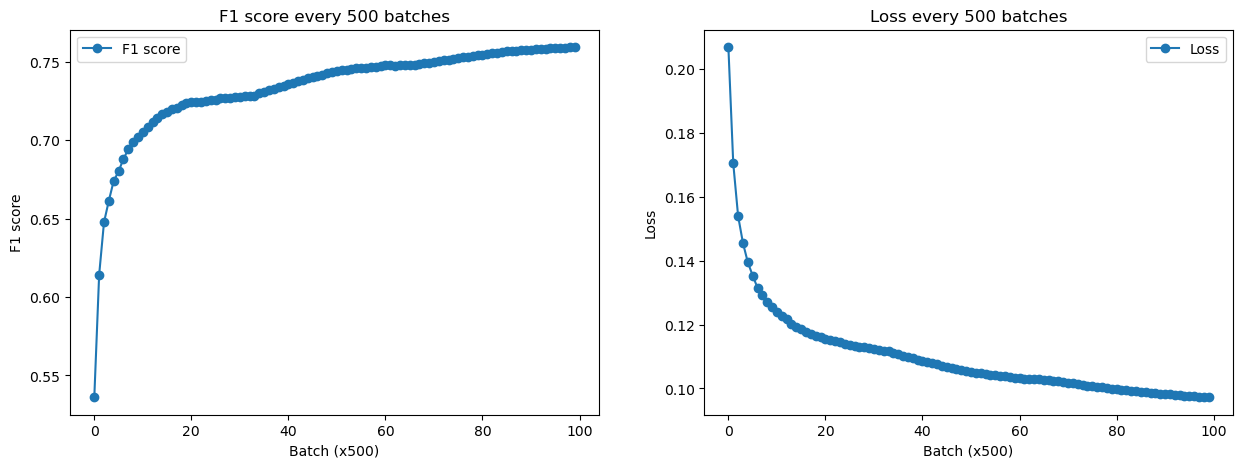

Training Loss: 0.0972 F1 score: 0.7593: 100%|██████████| 50000/50000 [50:32<00:00, 16.49it/s]


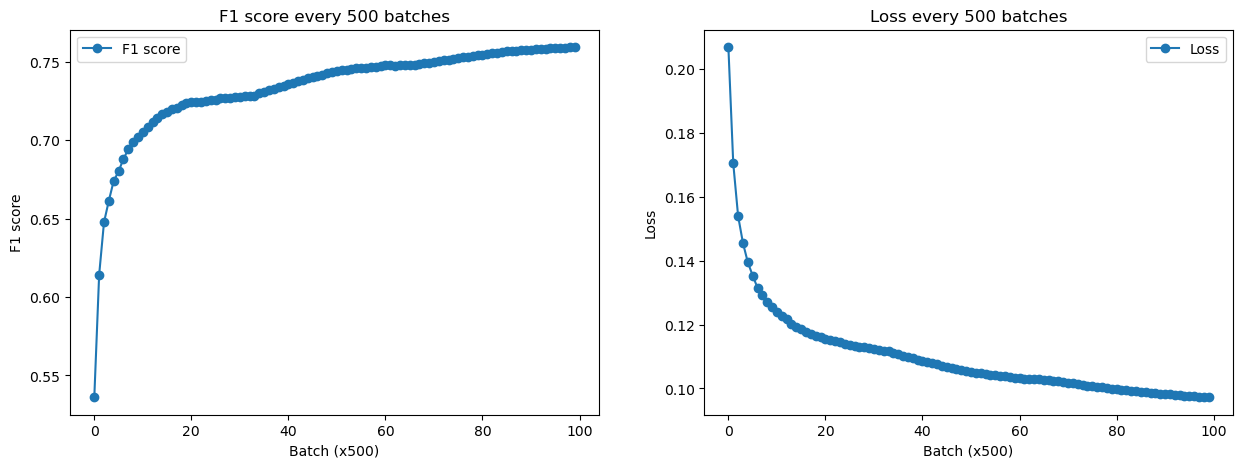

In [9]:
# cfg
BATCH_SIZE = 8

# Initialization of graphs and auxiliary variables for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('F1 score every 500 batches')
ax1.set_xlabel('Batch')
ax1.set_ylabel('F1 score')

ax2.set_title('Loss every 500 batches')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Loss')

running_loss = 0
running_f1 = 0

loss_values = []
f1_scores = []

# Setting the number of iterations for training
t = trange(50000, desc="Training", mininterval=0.5)

train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)

# Training loop
for i in t:
    
    # =================================================
    # Take a training step
    # =================================================
    optimizer.zero_grad() # Zeroing the gradients in the optimizer to prevent accumulation over multiple iterations

    try:
        inputs, masks, labels = next(train_generator, None)
    except StopIteration: # TODO this code duplication is kinda ugly
        train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)
        inputs, masks, labels = next(train_generator, None)
    
    output = punctuation_model(inputs.to(device), masks.to(device)) # Forward pass through the model
    output = output.permute(0,2,1) # Permutation of the model output to meet the expected dimensions for the loss criterion
    
    loss = criterion(output, labels.to(device)) # Calculation of the loss between predictions and actual labels
    loss.backward()
    
    optimizer.step()
    
    # =================================================
    # Track running stats
    # =================================================
    running_loss += loss.item()
    f1 = f1_score(torch.argmax(output.clone().detach().cpu(),1).view(-1),labels.view(-1), average=None)
    running_f1 += f1[1]
    t.set_description(f"Training Loss: {(running_loss/(i+1)):.4f} F1 score: {(running_f1/(i+1)):.4f}", refresh=True)
    t.refresh()

    # =================================================
    # Display results every 500 batches
    # =================================================
    if (i+1) % 500 == 0:  # Every 500 batches
        f1_scores.append(running_f1/(i+1))
        loss_values.append(running_loss/(i+1))
        
        # Clearing previous graphs
        ax1.clear()
        ax2.clear()

        # Setting titles and axes for both graphs
        ax1.set_title('F1 score every 500 batches')
        ax1.set_xlabel('Batch (x500)')
        ax1.set_ylabel('F1 score')
        ax2.set_title('Loss every 500 batches')
        ax2.set_xlabel('Batch (x500)')
        ax2.set_ylabel('Loss')

        # Updating the graph for F1 score
        ax1.plot(f1_scores, '-o', label='F1 score')
        ax1.legend()

        # Updating the graph for Loss
        ax2.plot(loss_values, '-o', label='Loss')
        ax2.legend()

        clear_output(wait=True)
        display(fig)  # Displays the current figure with both graphs




In [11]:
torch.save(punctuation_model, 'punctuation_model.pt')

In [16]:
punctuation_model = torch.load('punctuation_model.pt', weights_only=False)

In [17]:
# Function that takes text as input and generates output text with punctuation
def punctuate(text,model,tokenizer) -> str:
    table = ' .?,'
    model.eval()
        
    t = tokenizer(text, add_special_tokens=False)
    tokens = t['input_ids']
    strs = tokenizer.convert_ids_to_tokens(tokens)
    
    tokens = torch.tensor(tokens)[None, :]
    mask = torch.ones_like(tokens)
    outputs = model(tokens.to(device), mask.to(device))
    flag = outputs.argmax(axis=-1).squeeze()
    print(flag)

    text_output = ''
    for s, pun in zip(strs, flag):
        if s.startswith('##'):
            s = s[2:]
        elif s not in set(',.?!'):
            text_output += ' '
        if pun:
            s += table[pun]
        text_output += s
    
    return text_output[1:]

In [18]:
input_text = "Vítejte v Liberci kterým vás provede pan Kovář Pan Kovář tu žije již dvacet let"
print(punctuate(input_text, punctuation_model, tokenizer))

tensor([0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
vítejte v liberci, kterým vás provede pan kovář. pan kovář tu žije již dvacet let.


In [34]:
# Combined
input_text = "vítejte v liberci kterým vás provede pan kovář spolu s rodinou tu žije již dvacet let"
input_step = punctuate(input_text, punctuation_model, tokenizer)
print(capitalize(input_step, capitalization_model, tokenizer))

tensor([0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
 Vítejte v Liberci, kterým vás provede pan kovář. spolu s rodinou tu žije již dvacet let.
